In [ ]:
!pip install -q ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo
from statsmodels import api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
from scipy import stats

# fetch dataset
bike_sharing = fetch_ucirepo(id=275)

# data (as pandas dataframes)
X = bike_sharing.data.features
y = bike_sharing.data.targets


# Предобработка данных

In [ ]:
X.isna().sum()

,0
dteday,0
season,0
yr,0
mnth,0
hr,0
holiday,0
weekday,0
workingday,0
weathersit,0
temp,0


In [ ]:
y.isna().sum()

,0
cnt,0


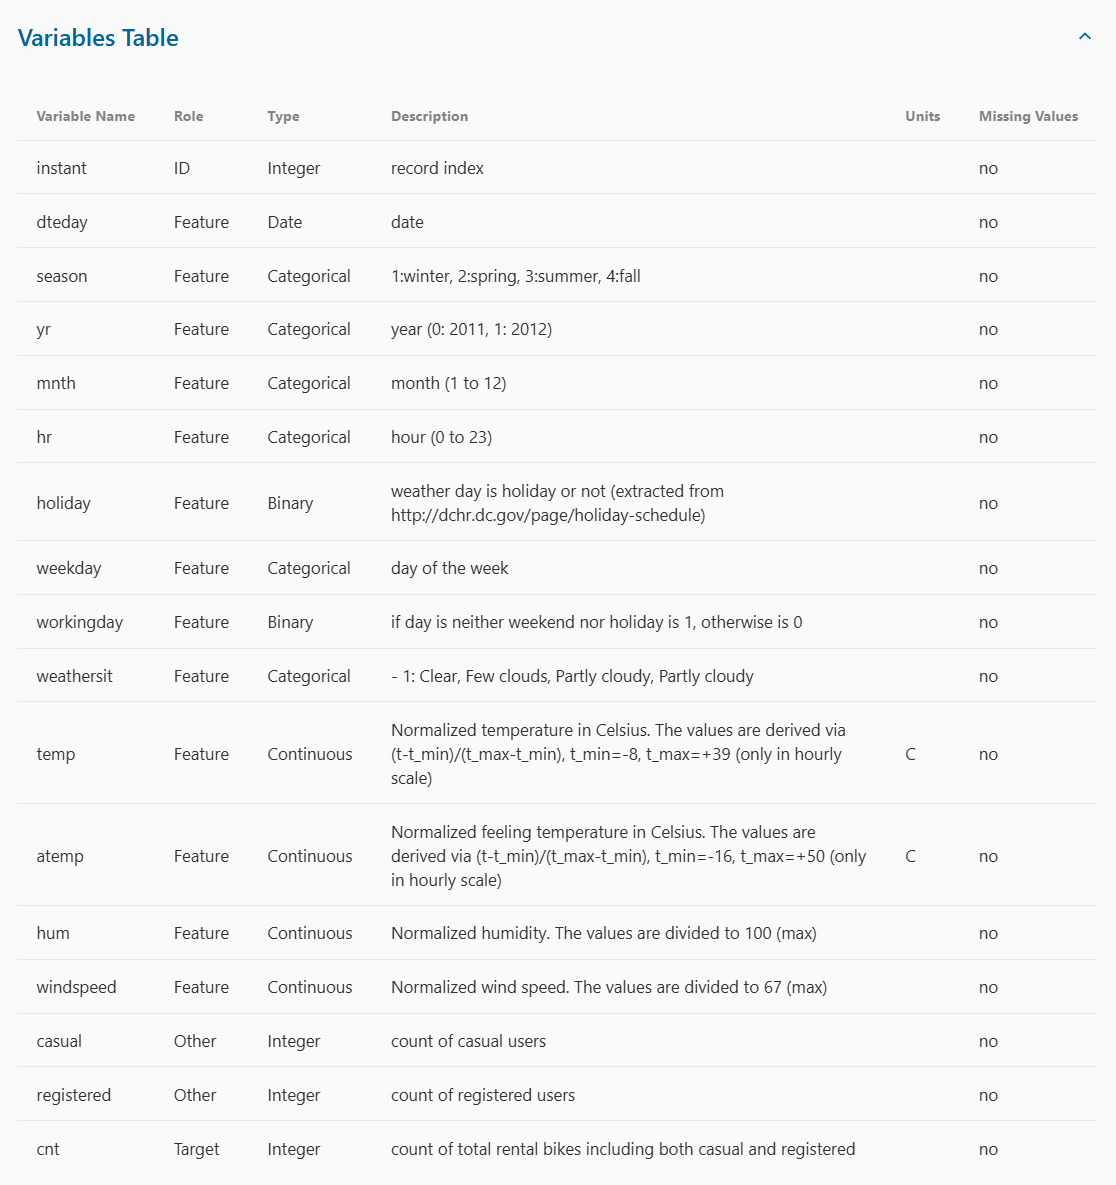

In [ ]:
X_continuous = X[['temp', 'atemp', 'hum', 'windspeed']] # отбираем только числовые признаки

# Первая модель

In [ ]:
X_const = sm.add_constant(X_continuous) # добавляем свободный член уравнения регрессии

model = sm.OLS(y, X_const) # строим модель

fit_results = model.fit() # фитим на данных

In [ ]:
rsq = fit_results.rsquared # R^2

y_pred = fit_results.predict(X_const)
mse = mean_squared_error(y, y_pred) # рассчитываем MSE на основе предсказаний модели

fvalue = fit_results.fvalue # F-value

print(f'F-value: {fvalue}, R^2: {rsq}, MSE: {mse} ')

F-value: 1474.1302776485202, R^2: 0.25339016185201135, MSE: 24563.141088011096 


Построенная модель линейной регрессии является статистически значимой (F = 1474.13, p < 0.001) и объясняет около 25 % вариации зависимой переменной (R² = 0.253). При этом среднеквадратическая ошибка составляет 24 563, что свидетельствует о наличии значительной непредсказанной части данных. Для повышения качества модели целесообразно рассмотреть добавление дополнительных предикторов и/или нелинейных зависимостей.

In [ ]:
vif = pd.DataFrame([[col for col in X_const.drop(columns='const').columns], [variance_inflation_factor(X_const.values, i+1) for i in range(len(X_const.columns[1:]))]])
# variance inflation factor как мера мультиколлинеарности

In [ ]:
vif

,0,1,2,3
0,temp,atemp,hum,windspeed
1,43.550327,43.65127,1.100575,1.156293


Между temp и atemp существует серьёзная мультиколлинеарность (VIF ~= 43).

In [ ]:
fit_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.253
Model:                            OLS   Adj. R-squared:                  0.253
Method:                 Least Squares   F-statistic:                     1474.
Date:                Thu, 16 Oct 2025   Prob (F-statistic):               0.00
Time:                        16:36:55   Log-Likelihood:            -1.1250e+05
No. Observations:               17379   AIC:                         2.250e+05
Df Residuals:                   17374   BIC:                         2.251e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        161.8069      6.506     24.872      0.000     149.055     174.559
temp          85.5765     40.751      2.100      0.036       5.700     165.453
atemp        314.3429     45.714      6.876      0.000     224.738     403.948
hum         -275.1803      6.466    -42.560      0.000    -287.854    -262.507
windspeed     42.9793     10.451      4.112      0.000      22.494      63.465
==============================================================================
Omnibus:                     3588.166   Durbin-Watson:                   0.420
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7224.742
Skew:                           1.237   Prob(JB):                         0.00
Kurtosis:                       4.964   Cond. No.                         71.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Модель статистически значима, но объясняет лишь около 25 % вариации зависимой переменной, следовательно, есть другие важные факторы (возможно, день недели, время суток, сезон, осадки и т. д.).

Самые сильные факторы: atemp, hum

Признаки temp и windspeed тоже значимы, но их вклад меньше.

In [ ]:
pd.concat((X_const, y), axis=1).corr()

,const,temp,atemp,hum,windspeed,cnt
const,NaN,NaN,NaN,NaN,NaN,NaN
temp,NaN,1.000000,0.987672,-0.069881,-0.023125,0.404772
atemp,NaN,0.987672,1.000000,-0.051918,-0.062336,0.400929
hum,NaN,-0.069881,-0.051918,1.000000,-0.290105,-0.322911
windspeed,NaN,-0.023125,-0.062336,-0.290105,1.000000,0.093234
cnt,NaN,0.404772,0.400929,-0.322911,0.093234,1.000000


По результатам регрессии значимостью обладают все факторы (p-value < 0.05), но:
1. VIF и матрица корреляции указывают на высокую степень взаимосвязи между temp и atemp
2. windspeed наименее коррелирует с зависимой переменной

На основании этого уберем из рассмотрения temp и windspeed.

# Новая модель

In [ ]:
X_new = X_const[['const', 'atemp', 'hum']]

In [ ]:
model_new = sm.OLS(y, X_new)

fit_results_new = model_new.fit()

In [ ]:
rsq = fit_results_new.rsquared # R^2

y_pred = fit_results_new.predict(X_new)
mse = mean_squared_error(y, y_pred) # рассчитываем MSE на основе предсказаний модели

fvalue = fit_results_new.fvalue # F-value

print(f'F-value: {fvalue}, R^2: {rsq}, MSE: {mse} ')

F-value: 2930.8970086914005, R^2: 0.25225260250598414, MSE: 24600.566298991125 


После исключения переменных temp и windspeed, которые вызывали мультиколлинеарность и не вносили значимого вклада в объяснение зависимой переменной, модель сохранила статистическую значимость (F = 2930.9, p < 0.001) и практически тот же уровень объясняющей способности (R² = 0.252). Среднеквадратическая ошибка (MSE = 24 600.6) изменилась несущественно. Это свидетельствует о том, что упрощённая модель с переменными atemp и hum является более надёжной и интерпретируемой без потери качества предсказания.

In [ ]:
vif = pd.DataFrame([[col for col in X_new.drop(columns='const').columns], [variance_inflation_factor(X_new.values, i+1) for i in range(len(X_new.columns[1:]))]])

In [ ]:
vif

,0,1
0,atemp,hum
1,1.002703,1.002703


Модель избавлена от мультиколлинеарности.

In [ ]:
fit_results_new.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.252
Model:                            OLS   Adj. R-squared:                  0.252
Method:                 Least Squares   F-statistic:                     2931.
Date:                Thu, 16 Oct 2025   Prob (F-statistic):               0.00
Time:                        16:36:55   Log-Likelihood:            -1.1252e+05
No. Observations:               17379   AIC:                         2.250e+05
Df Residuals:                   17376   BIC:                         2.251e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        174.6504      5.351     32.641      0.000     164.163     185.138
atemp        406.5809      6.933     58.641      0.000     392.991     420.171
hum         -284.7899      6.176    -46.113      0.000    -296.895    -272.685
==============================================================================
Omnibus:                     3567.194   Durbin-Watson:                   0.420
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7157.094
Skew:                           1.232   Prob(JB):                         0.00
Kurtosis:                       4.953   Cond. No.                         9.19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Простая модель с двумя переменными объясняет практически тот же процент вариации, но стала более стабильной.

R^2 почти не изменился, удаление temp и windspeed не уменьшило объясняемую дисперсию.

Увеличение F связано с устранением мультиколлинеарности, оставшиеся переменные дают более чистое объяснение.

Ошибки прогнозирования почти не увеличились (MSE ≈ 24 600).

In [ ]:
fit_results.compare_f_test(fit_results_new) # F-тест для сравнения двух моделей

(np.float64(13.235799388139272),
 np.float64(1.803599137572813e-06),
 np.float64(2.0))

p-value << 0.05 - старая модель эффективнее новой

# Условия Гаусса-Маркова

In [ ]:
residuals = fit_results_new.resid # остатки (Е) модели

In [ ]:
med = residuals.median()
signs = np.sign(residuals - med)
signs = signs[signs != 0]
runs = np.sum(np.diff(signs) != 0) + 1
n = len(signs)
n_pos = np.sum(signs > 0)
n_neg = np.sum(signs < 0)
exp_runs = (2 * n_pos * n_neg / n) + 1
var_runs = (2 * n_pos * n_neg * (2 * n_pos * n_neg - n)) / (n ** 2 * (n - 1))
z = (runs - exp_runs) / np.sqrt(var_runs) if var_runs > 0 else 0
p_val = 2 * (1 - stats.norm.cdf(abs(z)))
# runs test
f'runs: {runs}, exp_runs: {exp_runs}, z: {z}, p_value: {p_val}'

'runs: 2725, exp_runs: 8690.0, z: -90.5009303611447, p_value: 0.0'

Фактическое число серий (runs) намного меньше ожидаемого (exp_runs), то есть остатки очень сгруппированы по знакам.

Z-статистика очень большая по модулю при p << 0.05, следовательно, отклонение от случайного порядка экстремально. Это значит, что остатки не случайны и имеет место автокорреляция.

In [ ]:
skew = stats.skew(residuals) # асимметрия
kurt = stats.kurtosis(residuals) # эксцесс
shapiro_stat, shapiro_p = stats.shapiro(residuals) # тест шапиро-уилка

/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 17379.
  res = hypotest_fun_out(*samples, **kwds)


In [ ]:
f'асимметрия: {skew}, эксцесс: {kurt}, статистика: {shapiro_stat}, p-value: {shapiro_p}'

'асимметрия: 1.2319291199261393, эксцесс: 1.9527377291828145, статистика: 0.9193888571945029, p-value: 3.1254860516481977e-69'

skew > 1 - сильная правосторонняя асимметрия распределеиня остатков

kurtosis < 3 - плосковершинное распределение

shapiro_stat < 0.95 при p << 0.05 - распределение далеко от нормального

In [ ]:
dw = sm.stats.durbin_watson(residuals) # тест дарбина-уотсона

f'результат теста Дарбина-Уотсона: {dw}'

'результат теста Дарбина-Уотсона: 0.4200859765008472'

dw < 2 указывает на сильную положительную автокорреляцию остатков

In [ ]:
t_stat, p_val = stats.ttest_1samp(residuals, 0) # t-тест о равенстве среднего значения остатков нулю

f't-статистика: {t_stat}, p-value: {p_val}'

't-статистика: 7.512605791552137e-13, p-value: 0.9999999999994006'

t_stat близок к нулю при p > 0.05 - нет оснований отвергнуть гипотезу о равенстве среднего значения остатков нулю.